### **Detecção e Redução de Fraudes no Setor Financeiro**

# Bibliotecas e dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Bibliotecas para classificação
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter
from collections import Counter
from sklearn import metrics
from imblearn.under_sampling import ClusterCentroids
from yellowbrick.classifier import ROCAUC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
def colabOuCode(path_drive, path_local, ncolunas=None):
    '''
    Importa o DataFrame de acordo com a plataforma usada. Retorna um DataFrame.
    path_drive: caminho do arquivo no Google Colab
    path_local: caminho do arquivo na máquina local
    ncolunas: quantidade de colunas a serem importadas na máquina local
    '''
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df = pd.read_csv(path_drive)
    except:
        if ncolunas is None: df = pd.read_csv(path_local)
        else: df = pd.read_csv(path_local, nrows=ncolunas)
    return df

In [3]:
dt = 'data/fraud_detection_dataset.csv'
dd = '/content/drive/MyDrive/data/fraud_detection_dataset.csv'
data_fraude = colabOuCode(dt, dd, ncolunas=None)

Mounted at /content/drive


In [4]:
fraude = data_fraude[:]
#fraude = data_fraude.tail(1000000) #Selecionando apenas 100000 

In [5]:
fraude

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


# EDA

In [6]:
# Verificando os tipos de dados do dataset 
fraude.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Verificando valores ausentes. #Não há valores ausentes
fraude.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
# Verificando dados que foram classificados como fraude
fraude[fraude['isFraud'] ==1][:20]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.00,0.00,1,0


As fraudes acontecem em TRANSFER e CASH_OUT

In [9]:
# Verificando dados que foram classificados como fraude por transferência >200.000 
fraude[:][fraude['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


Dos 16 registros de fraude com valor >200.000, TODOS possuem as variáveis oldbalanceDest e newbalanceDest com 0.

As variáveis oldbalanceOrg e newbalanceOrg também possuem exatamente o mesmo valor, não é descontado o valor em dinheiro na transação.

In [10]:
fraude.describe() # A diferença de intervalos nos valores numéricos implica necessidade de normalização

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
# Verificar a distribuição da variável type, para ver quando a fraude ocorre com mais frequência

print(fraude['type'].value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


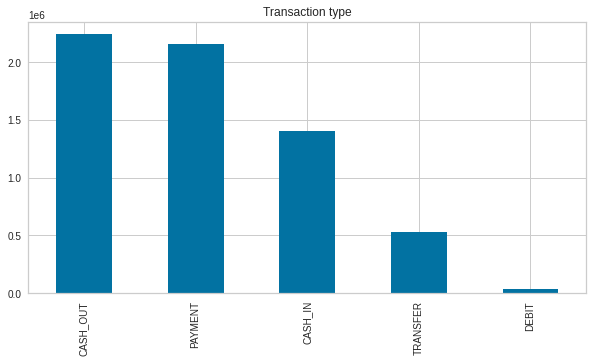

In [12]:
# Verificar a distribuição da variável type, para ver quando a fraude ocorre com mais frequência
print(fraude.type.value_counts())

f, ax = plt.subplots(figsize=(10, 5))
fraude.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(10,5))
plt.show()

In [13]:
fraude_isFraud = fraude[(fraude['isFraud'] == 1)]
fraude_isFraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


0    6354407
1       8213
Name: isFraud, dtype: int64


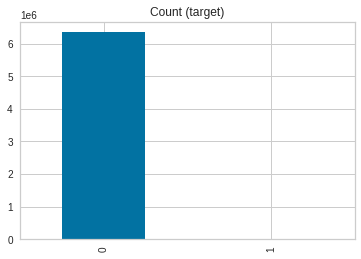

In [14]:
print(fraude['isFraud'].value_counts()) # De 6354407 dados, 8213 são fraude
fraude['isFraud'].value_counts().plot(kind='bar', title='Count (target)')

[Text(0, 0, 'Not Fraud'), Text(0, 0, 'Fraud')]

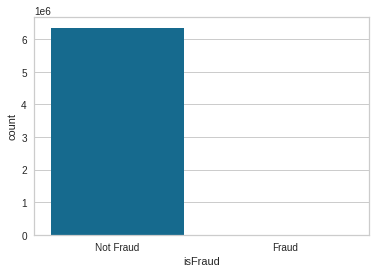

In [15]:
g = sns.countplot('isFraud', data=fraude)
g.set_xticklabels(['Not Fraud', 'Fraud'])

In [16]:
# Quais tipos de transações são mais comuns ao cometer fraudes?
print(fraude[(fraude['isFraud'] == 1)]['type'].value_counts())

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


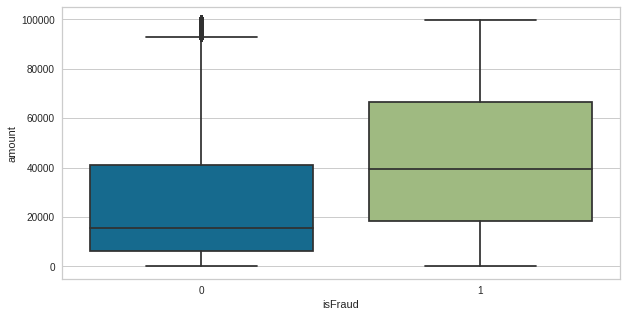

In [17]:
# Distribuicao de isFraud com amount
plt.figure(figsize=(10,5))
sns.boxplot(x = 'isFraud', y = 'amount', data = fraude[fraude.amount < 1e5]) #Fraude mais comum com valores mais altos

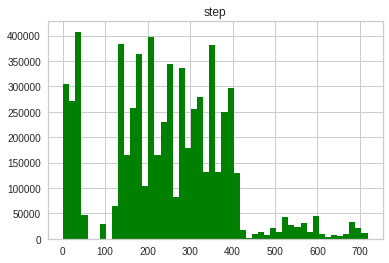

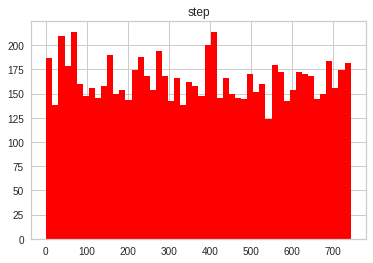

<Figure size 288x144 with 0 Axes>

In [18]:
# Variável step é o momento da simulação (30 dias), em que a transação é realizada
bins = 50

fraude[(fraude['isFraud'] == 0)].hist(column="step",color="green",bins=bins)

fraude[(fraude['isFraud'] == 1)].hist(column ="step",color="red",bins=bins)

plt.figure(figsize=(4,2))
plt.show()

Após a etapa 400 as transações reais diminuem consideravelmente, enquanto as fraudulentas permanecem constantes.

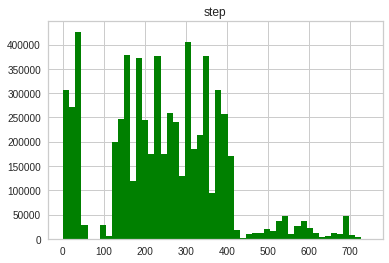

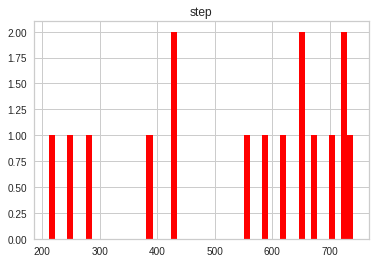

<Figure size 288x144 with 0 Axes>

In [19]:
bins = 50

fraude[(fraude['isFlaggedFraud'] == 0)].hist(column="step",color="green",bins=bins)

fraude[(fraude['isFlaggedFraud'] == 1)].hist(column ="step",color="red",bins=bins)

plt.figure(figsize=(4,2))
plt.show()

In [20]:
# Criando variáveis dummy e eliminando as categóricas
# Eliminando as contas de destino e origem porque não foram consideradas variáveis importantes
dataset = pd.concat([fraude.drop(columns=['isFraud','isFlaggedFraud']),pd.get_dummies(fraude.type)] ,axis=1)
dataset = dataset.drop(['type', 'nameOrig', 'nameDest'],1)
dataset = pd.concat([dataset,fraude.iloc[:,-2:]],axis=1)
pd.DataFrame.head(dataset)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0,0


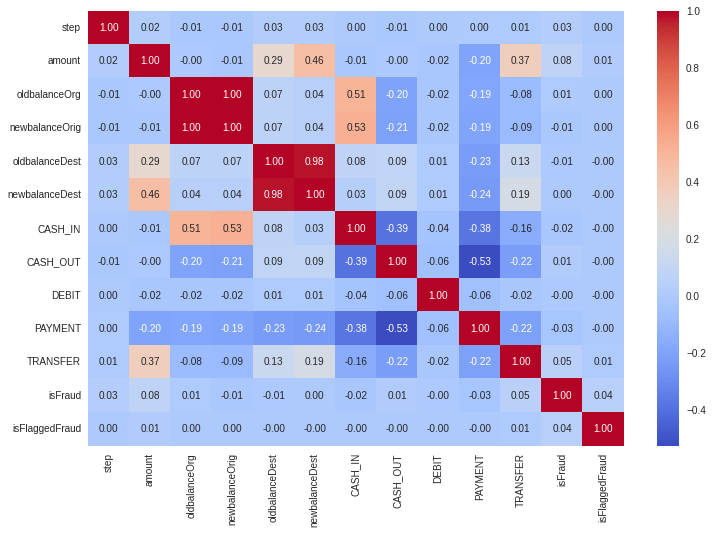

In [21]:
# Verificar a matriz de correlação entre as features
sns.set_context(font_scale=1.9)
plt.figure(figsize=(12,8))

sns.heatmap(
    dataset.corr(), 
    annot=True,    
    fmt='.2f',    
    cmap='coolwarm',   
)

plt.show()

In [22]:
# Matriz de correlação
quantitativas = dataset.iloc[:,:6]

In [23]:
quantitativas.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [24]:
corr_mat = quantitativas.corr(method="pearson")
corr_mat.style.background_gradient(cmap='coolwarm')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000


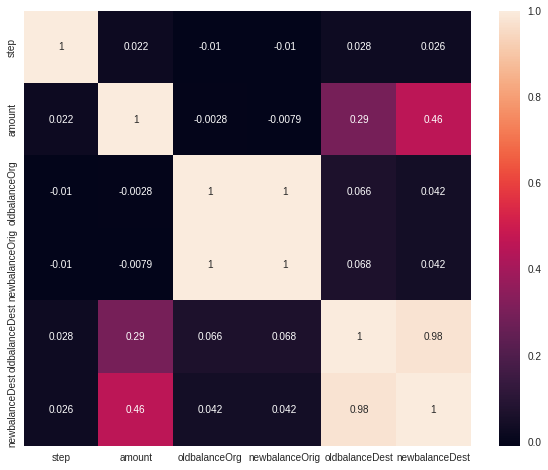

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True)
plt.show()

Correlação entre as seguintes variáveis: oldbalanceDest e newbalanceDest / oldbalanceOrg e newbalanceOrig. Isso porque quando o dinheiro é enviado a um destinatário, este aumenta seu capital, enquanto a origem diminui.

In [26]:
total = dataset['isFraud'].value_counts()[0] + fraude['isFraud'].value_counts()[1]
fraud = (fraude['isFraud'].value_counts()[1]/total) * 100
print('Porcentagem de fraude:', fraud)

Porcentagem de fraude: 0.12908204481801522


# Normalizacão dos dados

Como visto com a função describe(), há uma grande diferença na escala das variáveis numéricas. Vamos alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores. Com isso, ao usarmos amount, por exemplo, ele influenciará resultado pela sua característica mas não devido aos valores maiores.

In [27]:
dataset

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0,0,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0,0,0
2,1,181.00,181.00,0.00,0.00,0.00,0,0,0,0,1,1,0
3,1,181.00,181.00,0.00,21182.00,0.00,0,1,0,0,0,1,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,0,1,0,0,0,1,0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,1,1,0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,1,0,0,0,1,0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,1,1,0


In [28]:
#Resetando index para não ter problema na concatenação depois
dataset.reset_index(drop= True, inplace= True)

In [29]:
# normalizando com Z-score
col_names = dataset.iloc[:,:6].columns
col_names

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [30]:
s_scaler = StandardScaler()
df_s = s_scaler.fit_transform(dataset.iloc[:,:6])
df_s = pd.DataFrame(df_s, columns=col_names)

In [31]:
# Concatenando os dados normalizados
dfnormal = pd.concat([df_s, dataset.iloc[:,6:]], axis = 1)

In [32]:
# Observa-se que agora as variáveis estão em uma faixa mais semelhante.
dfnormal

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
0,-1.703042,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,0,1,0,0,0
1,-1.703042,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,0,1,0,0,0
2,-1.703042,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,0,0,0,0,1,1,0
3,-1.703042,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,0,1,0,0,0,1,0
4,-1.703042,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,3.510123,0.264665,-0.171108,-0.292442,-0.323814,-0.240959,0,1,0,0,0,1,0
6362616,3.510123,10.153953,1.896491,-0.292442,-0.323814,-0.333411,0,0,0,0,1,1,0
6362617,3.510123,10.153953,1.896491,-0.292442,-0.303665,1.403027,0,1,0,0,0,1,0
6362618,3.510123,1.109765,0.005581,-0.292442,-0.323814,-0.333411,0,0,0,0,1,1,0


# Divisão do Dataset

In [33]:
#Separar dados em treino e teste
X = dfnormal.drop(columns = ['isFraud', 'isFlaggedFraud'])
y = dfnormal['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# **Balanceamento das Classes**

Testaremos algumas formas de balanceamento dos dados, pois temos muitas informações a respeito de transações que não são fraudes, e muito pouca informação a respeito da categoria fraude, que é a que nos interessa. 

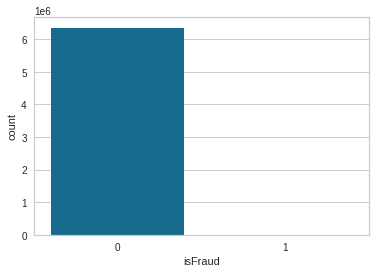

In [ ]:
# Visualização da variável de interesse
g = sns.countplot(y)
plt.show()

In [ ]:
len(X_train)

4262955

In [ ]:
len(X_test)

2099665

## Baseline - Regressão Logística

In [34]:
logreg_baseline = LogisticRegression(max_iter=200)
logreg_baseline.fit(X_train, y_train)

y_pred_baseline = logreg_baseline.predict(X_test)

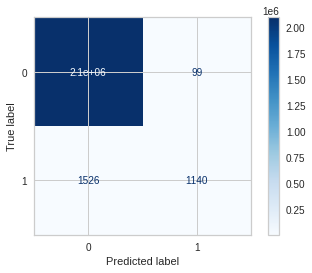

In [35]:
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_baseline.classes_)
disp.plot(cmap='Blues')

In [36]:
print(classification_report(y_test, y_pred_baseline, target_names=['Fraud', 'Not Fraud']))

              precision    recall  f1-score   support

       Fraud       1.00      1.00      1.00   2096999
   Not Fraud       0.92      0.43      0.58      2666

    accuracy                           1.00   2099665
   macro avg       0.96      0.71      0.79   2099665
weighted avg       1.00      1.00      1.00   2099665



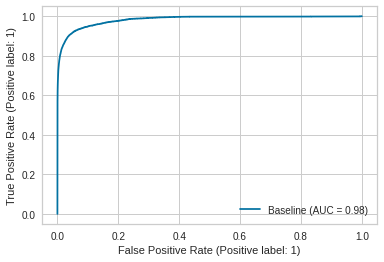

In [37]:
metrics.plot_roc_curve(logreg_baseline, X_train, y_train, name='Baseline')
plt.show()

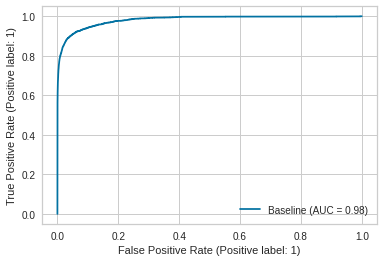

In [38]:
metrics.plot_roc_curve(logreg_baseline, X_test, y_test, name='Baseline')
plt.show()

## Logistic Regression - Classes Weights ('balanced')

In [60]:
logreg_balanced = LogisticRegression(class_weight='balanced')
logreg_balanced.fit(X_train, y_train)
y_pred = logreg_balanced.predict(X_test)

In [61]:
confusion_matrix(y_test, y_pred)

array([[1991422,  105577],
       [    150,    2516]])

In [62]:
print(classification_report(y_test, y_pred, target_names=['Fraud', 'Not Fraud']))

              precision    recall  f1-score   support

       Fraud       1.00      0.95      0.97   2096999
   Not Fraud       0.02      0.94      0.05      2666

    accuracy                           0.95   2099665
   macro avg       0.51      0.95      0.51   2099665
weighted avg       1.00      0.95      0.97   2099665



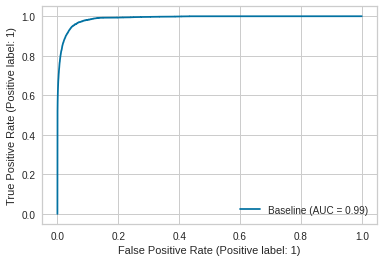

In [63]:
metrics.plot_roc_curve(logreg_balanced, X_train, y_train, name='Baseline')
plt.show()

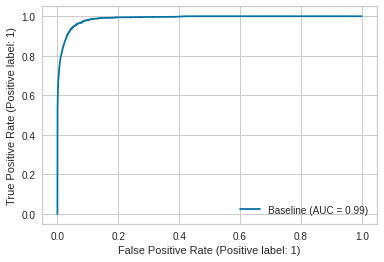

In [64]:
metrics.plot_roc_curve(logreg_balanced, X_test, y_test, name='Baseline')
plt.show()

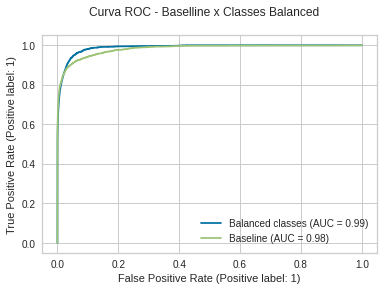

In [65]:
logreg_balanced_disp = metrics.plot_roc_curve(logreg_balanced, X_test, y_test, 
                                              name='Balanced classes')
logreg_baseline_disp = metrics.plot_roc_curve(logreg_baseline, X_test, y_test,
                                              name='Baseline', 
                                              ax=logreg_balanced_disp.ax_)
logreg_baseline_disp.figure_.suptitle("Curva ROC - Baselline x Classes Balanced")

plt.show()

## Balanceamento dos Dados com Over-Sampling (ADASYN)

In [66]:
ada = ADASYN(random_state=42, sampling_strategy=0.22, n_jobs=-1)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print('Resultado após o oversampling %s' % Counter(y_ada))

Resultado após o oversampling Counter({0: 4257408, 1: 937214})


In [67]:
len(X_ada[y_ada == 0])

4257408

In [68]:
len(X_ada[y_ada == 1])

937214

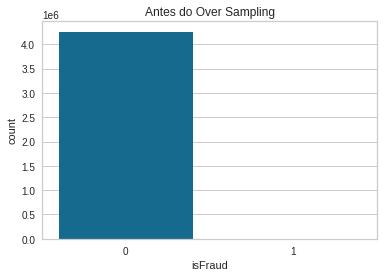

In [69]:
g = sns.countplot(y_train)
plt.title("Antes do Over Sampling")
plt.show()

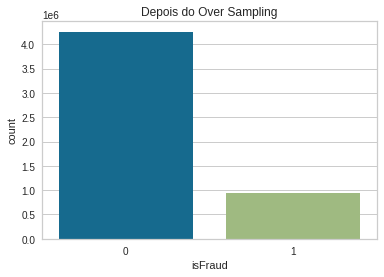

In [70]:
g = sns.countplot(y_ada)
plt.title("Depois do Over Sampling")
plt.show()

In [71]:
logreg2 = LogisticRegression(n_jobs=-1)
logreg2.fit(X_ada, y_ada)
y_pred2 = logreg2.predict(X_test)

In [72]:
confusion_matrix(y_test, y_pred2)

array([[2049708,   47291],
       [    122,    2544]])

In [73]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   2096999
           1       0.05      0.95      0.10      2666

    accuracy                           0.98   2099665
   macro avg       0.53      0.97      0.54   2099665
weighted avg       1.00      0.98      0.99   2099665



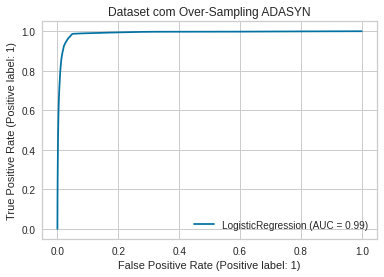

In [74]:
metrics.plot_roc_curve(logreg2, X_ada, y_ada)
plt.title("Dataset com Over-Sampling ADASYN")
plt.show()

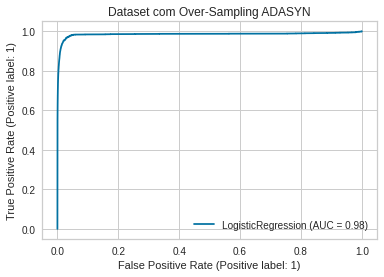

In [75]:
metrics.plot_roc_curve(logreg2, X_test, y_test)
plt.title("Dataset com Over-Sampling ADASYN")
plt.show()

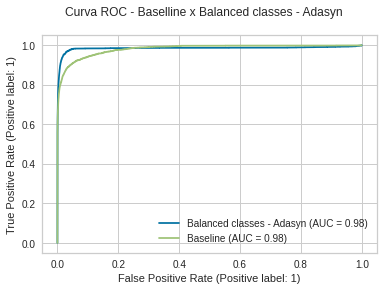

In [76]:
logreg_balanced_disp = metrics.plot_roc_curve(logreg2, X_test, y_test, 
                                              name='Balanced classes - Adasyn')
logreg_baseline_disp = metrics.plot_roc_curve(logreg_baseline, X_test, y_test,
                                              name='Baseline', 
                                              ax=logreg_balanced_disp.ax_)
logreg_baseline_disp.figure_.suptitle("Curva ROC - Baselline x Balanced classes - Adasyn")

plt.show()

## Balanceamento dos Dados com Over-Sampling (SMOTE)

In [39]:
smo = SMOTE(random_state=42, sampling_strategy=0.22, n_jobs=-1)
X_smo, y_smo = smo.fit_resample(X_train, y_train)
print('Resultado após o oversampling %s' % Counter(y_smo))

Resultado após o oversampling Counter({0: 4257408, 1: 936629})


In [40]:
len(X_smo[y_smo == 0])

4257408

In [41]:
len(X_smo[y_smo == 1])

936629

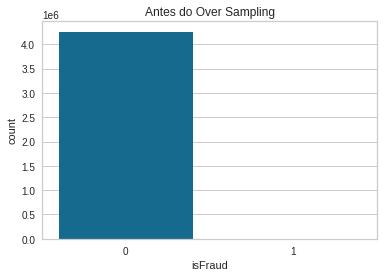

In [42]:
g = sns.countplot(y_train)
plt.title("Antes do Over Sampling")
plt.show()

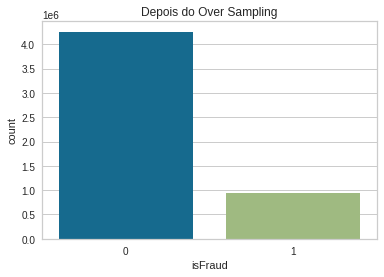

In [43]:
g = sns.countplot(y_smo)
plt.title("Depois do Over Sampling")
plt.show()

In [44]:
logreg3 = LogisticRegression(n_jobs=-1)
logreg3.fit(X_smo, y_smo)
y_pred3 = logreg3.predict(X_test)

In [45]:
confusion_matrix(y_test, y_pred3)

array([[2071482,   25517],
       [    372,    2294]])

In [46]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   2096999
           1       0.08      0.86      0.15      2666

    accuracy                           0.99   2099665
   macro avg       0.54      0.92      0.57   2099665
weighted avg       1.00      0.99      0.99   2099665



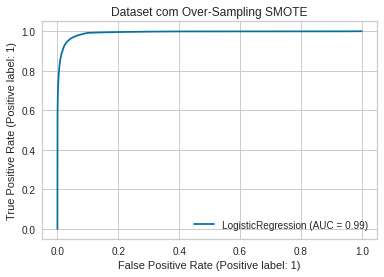

In [47]:
metrics.plot_roc_curve(logreg3, X_smo, y_smo)
plt.title("Dataset com Over-Sampling SMOTE")
plt.show()

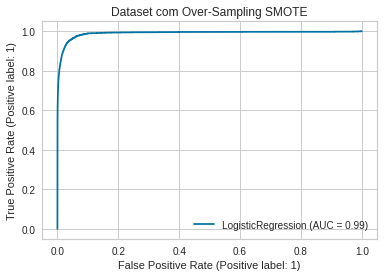

In [48]:
metrics.plot_roc_curve(logreg3, X_test, y_test)
plt.title("Dataset com Over-Sampling SMOTE")
plt.show()

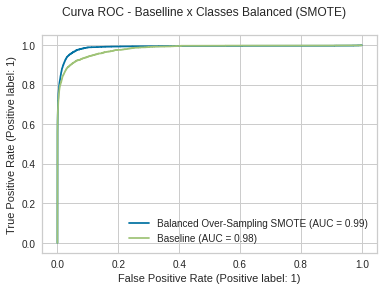

In [49]:
logreg_balanced_disp = metrics.plot_roc_curve(logreg3, X_test, y_test, 
                                              name='Balanced Over-Sampling SMOTE')
logreg_baseline_disp = metrics.plot_roc_curve(logreg_baseline, X_test, y_test,
                                              name='Baseline', 
                                              ax=logreg_balanced_disp.ax_)
logreg_baseline_disp.figure_.suptitle("Curva ROC - Baselline x Classes Balanced (SMOTE)")

plt.show()

## Análise do Balanceamento

In [50]:
infor = {'Estratégia': ['Baseline RL', 'RL', 'ADASYN', 'SMOTE'], 
          'Acurácia': [1, 0.95, 0.98, 0.99], 
          'Precision': [1, 1, 1, 1], 
          'Recall': [1, 0.95, 0.98, 0.99], 
          'F1 Score': [1, 0.97, 0.99, 0.99], 
          'AUC': [0.98, 0.99, 0.99, 0.99]}
resultado_balanceamento = pd.DataFrame(data=infor)


In [51]:
resultado_balanceamento

,Estratégia,Acurácia,Precision,Recall,F1 Score,AUC
0,Baseline RL,1.00,1,1.00,1.00,0.98
1,RL,0.95,1,0.95,0.97,0.99
2,ADASYN,0.98,1,0.98,0.99,0.99
3,SMOTE,0.99,1,0.99,0.99,0.99


# Análise dos Resultados

Foi escolhido o balanceamento por SMOTE para aplicar o modelo de classificação.

In [52]:
#Construção do dataset para análises finais
y_df = pd.DataFrame(y_smo, columns=['isFraud'])

X_df = pd.DataFrame(X_smo, columns=['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 
                                    'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'])

newdf = pd.concat([X_df, y_df], axis=1)
newdf

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,-0.782658,0.011812,-0.286992,-0.226788,0.430916,0.272389,1,0,0,0,0,0
1,-0.775632,-0.154812,-0.277817,-0.292442,-0.323814,-0.309902,0,1,0,0,0,0
2,-0.782658,0.058999,-0.281266,-0.292442,1.543035,1.515994,0,1,0,0,0,0
3,2.421120,0.856919,-0.279890,-0.292442,0.308762,0.441618,0,0,0,0,1,0
4,0.559275,-0.199746,-0.278371,-0.292442,-0.323814,-0.333411,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5194032,-1.524852,0.155357,-0.193961,-0.292442,0.661015,0.652206,0,1,0,0,0,1
5194033,-0.331480,1.597426,0.107539,-0.292442,0.753570,0.974845,0,1,0,0,0,1
5194034,0.755845,0.082281,-0.209240,-0.292442,-0.323814,-0.270935,0,1,0,0,0,1
5194035,3.420432,-0.014484,-0.229471,-0.292442,-0.082829,-0.063887,0,1,0,0,0,1


## Decision tree

### Decision Tree com dados desbalanceados

In [53]:
train_X, test_X, train_y, test_y = train_test_split(dfnormal.drop(columns=["isFraud", "isFlaggedFraud"]), dfnormal.isFraud, test_size=1/7.0, random_state=0)

DT = tree.DecisionTreeClassifier()

DT.fit(train_X, train_y)

predictions = DT.predict(test_X)

In [54]:
print(DT.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT.predict(test_X)))

0.9997161547550679
[[907653    124]
 [   134   1035]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.89      0.89      0.89      1169

    accuracy                           1.00    908946
   macro avg       0.95      0.94      0.94    908946
weighted avg       1.00      1.00      1.00    908946



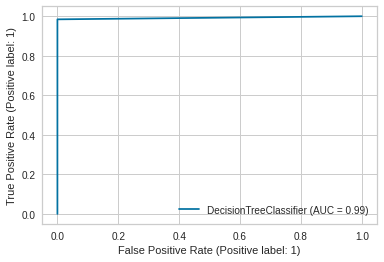

In [55]:
plot_roc_curve(DT, X_train, y_train)

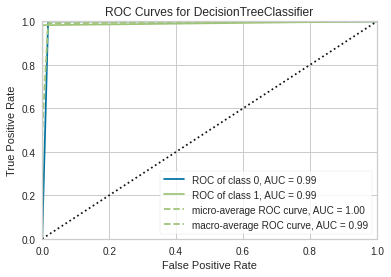

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc627b51210>,
       estimator=DecisionTreeClassifier())

In [56]:
roc_auc(DT, X_train, y_train, X_test=X_test, y_test=y_test)

In [57]:
DT.score(X_train, y_train)

0.999961294454199

In [58]:
DT.score(X_test, y_test)

0.9999557072199613

### Decision Tree com dados balanceados

In [59]:
train_X, test_X, train_y, test_y = train_test_split(newdf.drop(columns=["isFraud"]), newdf.isFraud, test_size=1/7.0, random_state=0)

DT2 = tree.DecisionTreeClassifier()

DT2.fit(train_X, train_y)

predictions = DT2.predict(test_X)

In [60]:
print(DT2.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, DT2.predict(test_X)))

0.9993571480554065
[[607983    337]
 [   140 133546]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    608320
           1       1.00      1.00      1.00    133686

    accuracy                           1.00    742006
   macro avg       1.00      1.00      1.00    742006
weighted avg       1.00      1.00      1.00    742006



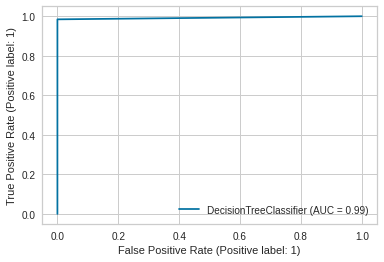

In [61]:
plot_roc_curve(DT, X_train, y_train)

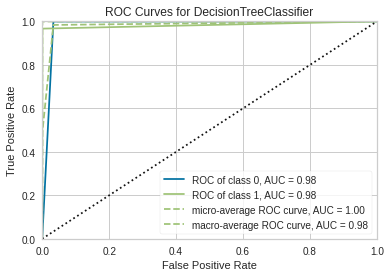

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc629749410>,
       estimator=DecisionTreeClassifier())

In [64]:
roc_auc(DT2, X_train, y_train, X_test=X_test, y_test=y_test)

In [62]:
DT2.score(X_train, y_train)

0.9999204776968089

In [63]:
DT2.score(X_test, y_test)

0.999397999204635

## Random Forest

### Random Forest com dados desbalanceados

In [94]:
train_X, test_X, train_y, test_y = train_test_split(dfnormal.drop(columns=["isFraud", 'isFlaggedFraud']), dfnormal.isFraud, test_size=1/7.0, random_state=0)

RF = RandomForestClassifier()

RF.fit(train_X, train_y)

predictions = RF.predict(test_X)

In [95]:
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.9997227558072757
[[907763     14]
 [   238    931]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.99      0.80      0.88      1169

    accuracy                           1.00    908946
   macro avg       0.99      0.90      0.94    908946
weighted avg       1.00      1.00      1.00    908946



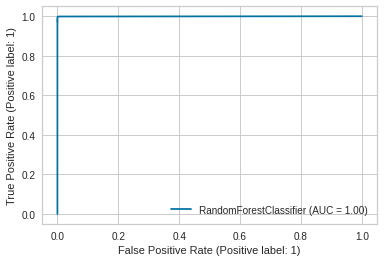

In [96]:
plot_roc_curve(RF, X_train, y_train)

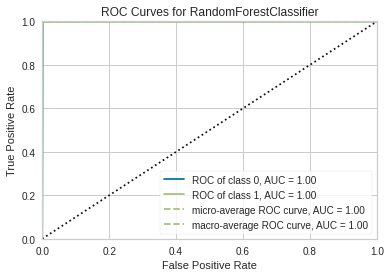

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc627a09bd0>,
       estimator=RandomForestClassifier())

In [97]:
roc_auc(RF, X_train, y_train, X_test=X_test, y_test=y_test)

In [98]:
RF.score(X_train, y_train)

0.9999596524007408

In [99]:
DT.score(X_test, y_test)

0.9999557072199613

### Random Forest com dados balanceados

In [100]:
train_X, test_X, train_y, test_y = train_test_split(newdf.drop(columns=["isFraud"]), newdf.isFraud, test_size=1/7.0, random_state=0)

RF2 = RandomForestClassifier()

RF2.fit(train_X, train_y)

predictions = RF2.predict(test_X)

In [101]:
print(RF2.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF2.predict(test_X)))

0.9993342371894567
[[607887    433]
 [    61 133625]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    608320
           1       1.00      1.00      1.00    133686

    accuracy                           1.00    742006
   macro avg       1.00      1.00      1.00    742006
weighted avg       1.00      1.00      1.00    742006



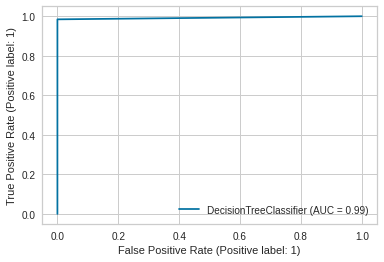

In [102]:
plot_roc_curve(DT, X_train, y_train)

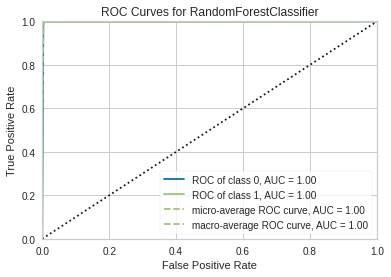

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc62c384190>,
       estimator=RandomForestClassifier())

In [103]:
roc_auc(RF2, X_train, y_train, X_test=X_test, y_test=y_test)

In [104]:
RF2.score(X_train, y_train)

0.9998970197902629

In [105]:
RF2.score(X_test, y_test)

0.9992408312754654

## Regressão Logística

### Regressão Logística com dados desbalanceados

In [67]:
train_X, test_X, train_y, test_y = train_test_split(dfnormal.drop(columns=["isFraud", 'isFlaggedFraud']), dfnormal.isFraud, test_size=1/7.0, random_state=0)

LR = LogisticRegression()

LR.fit(train_X, train_y)

predictions = LR.predict(test_X)

In [68]:
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.9992221760148567
[[907727     50]
 [   657    512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.91      0.44      0.59      1169

    accuracy                           1.00    908946
   macro avg       0.96      0.72      0.80    908946
weighted avg       1.00      1.00      1.00    908946



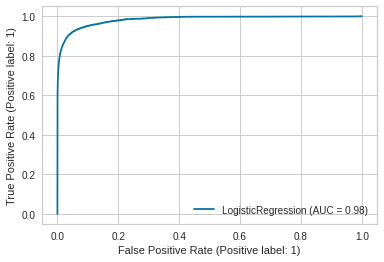

In [69]:
plot_roc_curve(LR, X_train, y_train)

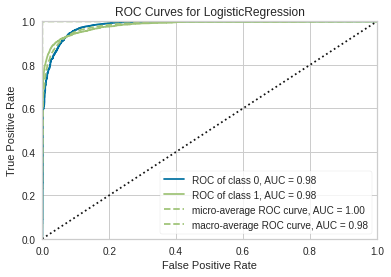

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc62c18fcd0>,
       estimator=LogisticRegression())

In [71]:
roc_auc(LR, X_train, y_train, X_test=X_test, y_test=y_test)

In [72]:
LR.score(X_train, y_train)

0.9992197900282785

In [73]:
LR.score(X_test, y_test)

0.999235116078041

### Regressão Logística com dados balanceados

In [74]:
train_X, test_X, train_y, test_y = train_test_split(newdf.drop(columns=["isFraud"]), newdf.isFraud, test_size=1/7.0, random_state=0)

LR2 = LogisticRegression()

LR2.fit(train_X, train_y)

predictions = LR2.predict(test_X)

In [75]:
print(LR2.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR2.predict(test_X)))

0.9681107699937737
[[600913   7407]
 [ 16255 117431]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    608320
           1       0.94      0.88      0.91    133686

    accuracy                           0.97    742006
   macro avg       0.96      0.93      0.94    742006
weighted avg       0.97      0.97      0.97    742006



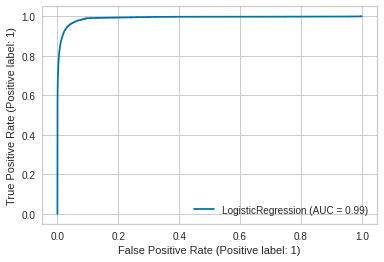

In [76]:
plot_roc_curve(LR2, X_train, y_train)

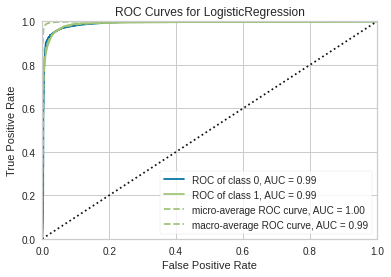

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc62c123690>,
       estimator=LogisticRegression())

In [77]:
roc_auc(LR2, X_train, y_train, X_test=X_test, y_test=y_test)

In [78]:
LR2.score(X_train, y_train)

0.9877181438696866

In [79]:
LR2.score(X_test, y_test)

0.9877518556531637

## XGBoosting

### XGB com dados desbalanceados

In [80]:
train_X, test_X, train_y, test_y = train_test_split(dfnormal.drop(columns=["isFraud", "isFlaggedFraud"]), dfnormal.isFraud, test_size=1/7.0, random_state=0)

XG = XGBClassifier()

XG.fit(train_X, train_y)

predictions = XG.predict(test_X)

[14:14:49] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [81]:
print(XG.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, XG.predict(test_X)))

0.9996061372182726
[[907763     14]
 [   344    825]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    907777
           1       0.98      0.71      0.82      1169

    accuracy                           1.00    908946
   macro avg       0.99      0.85      0.91    908946
weighted avg       1.00      1.00      1.00    908946



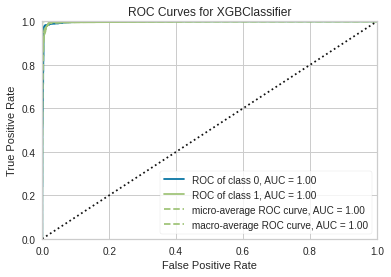

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc629738910>,
       estimator=XGBClassifier())

In [82]:
roc_auc(XG, X_train, y_train, X_test=X_test, y_test=y_test)

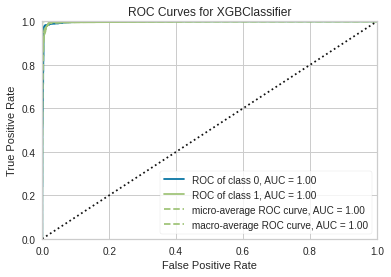

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6297892d0>,
       estimator=XGBClassifier())

In [83]:
roc_auc(XG, X_train, y_train, X_test=X_test, y_test=y_test)

In [84]:
XG.score(X_train, y_train)

0.9995915978470333

In [85]:
XG.score(X_test, y_test)

0.9995899345848028

### XGB com dados balanceados

In [86]:
train_X, test_X, train_y, test_y = train_test_split(newdf.drop(columns=["isFraud"]), newdf.isFraud, test_size=1/7.0, random_state=0)

XG2 = XGBClassifier()

XG2.fit(train_X, train_y)

predictions = XG2.predict(test_X)

[14:28:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [87]:
print(XG2.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, XG2.predict(test_X)))

0.9916186661563383
[[604642   3678]
 [  2541 131145]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    608320
           1       0.97      0.98      0.98    133686

    accuracy                           0.99    742006
   macro avg       0.98      0.99      0.99    742006
weighted avg       0.99      0.99      0.99    742006



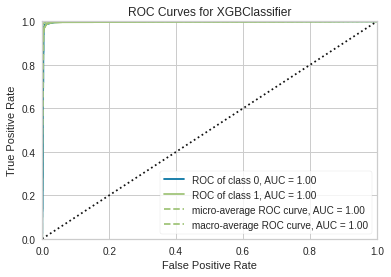

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc61b1a9290>,
       estimator=XGBClassifier())

In [88]:
roc_auc(XG2, X_train, y_train, X_test=X_test, y_test=y_test)

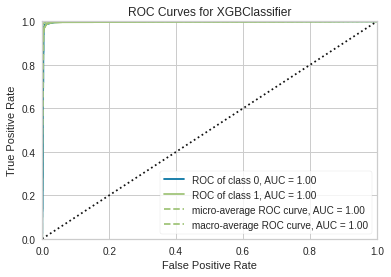

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc61b1270d0>,
       estimator=XGBClassifier())

In [89]:
roc_auc(XG2, X_train, y_train, X_test=X_test, y_test=y_test)

In [90]:
XG2.score(X_train, y_train)

0.9938955489795224

In [91]:
XG2.score(X_test, y_test)

0.9937794838700459

# Comparando os modelos

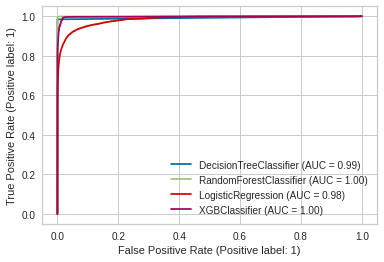

In [106]:
#Dados desbalanceados
classifiers = [DT, RF, LR, XG]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_train, y_train, ax=ax)

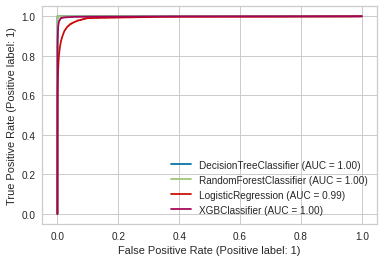

In [107]:
#Dados balanceados
classifiers = [DT2, RF2, LR2, XG2]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_train, y_train, ax=ax)

Com o classificador XGBoosting com dados desbalanceados, 69% das fraudes foram detectadas corretamente com uma taxa de falso negativo bem pequena (14 transações).